# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [6]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-3, 1e-2]
regularization_strengths = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]

results = {}
best_val = -1
best_svm = None

for a in learning_rates:
    for r in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=a, reg=r,
                      num_iters=1000, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_acc = np.mean(y_val == y_val_pred)
        results[(a, r)] = (train_acc, val_acc)
        if (best_val == -1 or best_val < val_acc):
            best_val = val_acc
            best_svm = svm

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 8.977950
iteration 100 / 1000: loss 4.962041
iteration 200 / 1000: loss 3.812223
iteration 300 / 1000: loss 3.665264
iteration 400 / 1000: loss 3.896209
iteration 500 / 1000: loss 4.105661
iteration 600 / 1000: loss 3.432987
iteration 700 / 1000: loss 3.265252
iteration 800 / 1000: loss 3.253212
iteration 900 / 1000: loss 3.647806
iteration 0 / 1000: loss 9.002796
iteration 100 / 1000: loss 4.777993
iteration 200 / 1000: loss 3.991441
iteration 300 / 1000: loss 3.735690
iteration 400 / 1000: loss 3.379882
iteration 500 / 1000: loss 3.380112
iteration 600 / 1000: loss 3.257219
iteration 700 / 1000: loss 3.350578
iteration 800 / 1000: loss 3.222920
iteration 900 / 1000: loss 3.568066
iteration 0 / 1000: loss 9.010338
iteration 100 / 1000: loss 4.578900
iteration 200 / 1000: loss 4.250614
iteration 300 / 1000: loss 3.990243
iteration 400 / 1000: loss 3.792947
iteration 500 / 1000: loss 4.144834
iteration 600 / 1000: loss 3.349685
iteration 700 / 1000: loss 3.39954

In [7]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.487


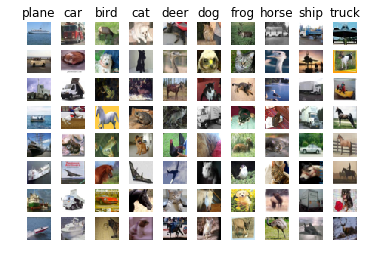

In [8]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [9]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [30]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_size = X_train_feats.shape[1]
num_classes = 10

best_net = None

dic = {500: [0, 2e-7, 1e-6], 700: [0, 2e-7, 1e-6]}
best = -1

for hidden, regs in dic.items():
    hidden_size = hidden
    net = TwoLayerNet(input_size, hidden_size, num_classes)
    for r in regs:
        # Train the network
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=2000, batch_size=200,
            learning_rate=0.2, learning_rate_decay=0.95,
            reg=r, verbose=False)
        
        print('hidden = %f , reg = %f' % (hidden, r))
        print('train : %f' % stats['train_acc_history'][-1])
        print('val : %f' % stats['val_acc_history'][-1])
        if stats['val_acc_history'][-1] > best:
            best_net = net

iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 2.130816
iteration 200 / 2000: loss 1.520707
iteration 300 / 2000: loss 1.544462
iteration 400 / 2000: loss 1.404922
iteration 500 / 2000: loss 1.296450
iteration 600 / 2000: loss 1.289794
iteration 700 / 2000: loss 1.324356
iteration 800 / 2000: loss 1.230858
iteration 900 / 2000: loss 1.132201
iteration 1000 / 2000: loss 1.301581
iteration 1100 / 2000: loss 1.216441
iteration 1200 / 2000: loss 1.164169
iteration 1300 / 2000: loss 1.197852
iteration 1400 / 2000: loss 1.170978
iteration 1500 / 2000: loss 1.031452
iteration 1600 / 2000: loss 1.132840
iteration 1700 / 2000: loss 1.074302
iteration 1800 / 2000: loss 1.178284
iteration 1900 / 2000: loss 1.158458
hidden = 500.000000 , reg = 0.000000
train : 0.670000
val : 0.589000
iteration 0 / 2000: loss 1.135800
iteration 100 / 2000: loss 0.967427
iteration 200 / 2000: loss 1.048952
iteration 300 / 2000: loss 1.093182
iteration 400 / 2000: loss 1.056088
iteration 500 / 2000: los

In [31]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.593
